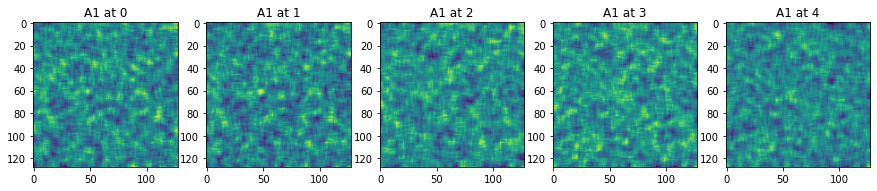

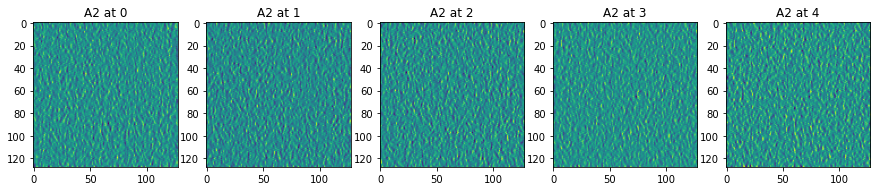

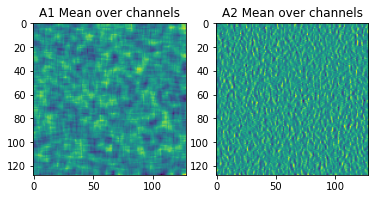

In [44]:
import numpy as np
from scipy.ndimage import convolve
from matplotlib import pyplot as plt
%matplotlib inline
channels = 5
hw = 128

# Create some Activation tensors
A1 = np.random.randn(channels,hw,hw)
A2 = np.random.rand(channels,hw,hw)

# make one low frequency  
filt = np.ones((3,6,6))
filt = filt / np.sum(filt)
A1 = convolve(A1,filt)
A1 = A1 - np.mean(A1)

# make one high frequency
filt = np.ones((2,3,3))
filt = filt / np.sum(filt)
filt[:,:,0] = filt[:,:,0]*(-1)
filt[:,:,1] = 0
A2 = convolve(A2,filt)
A2 = A2 - np.mean(A2)

# plot each tensor, average along channel
def show_active(A,title=''):
    plt.imshow(np.mean(A,0))
    plt.title(title)

plt.figure(figsize=(15,5))   
for i in range(channels):
    plt.subplot(1,channels,i+1)
    plt.imshow(A1[i,:,:])
    plt.title(f'A1 at {i}')
    
plt.figure(figsize=(15,5))   
for i in range(channels):
    plt.subplot(1,channels,i+1)
    plt.imshow(A2[i,:,:])
    plt.title(f'A2 at {i}')
    
plt.figure()
plt.subplot(1,2,1)
show_active(A1,'A1 Mean over channels')
plt.subplot(1,2,2)
show_active(A2,'A2 Mean over channels')

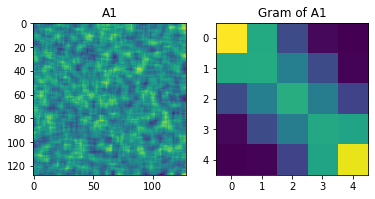

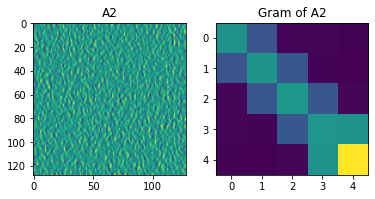

In [45]:
# calculate gram matrix (vectorized spatially) and show it
# for each activations
def gram(x):
    tmp = x.reshape((channels,hw*hw))
    return tmp @ tmp.T / (channels*hw*hw)

def show_gram(A,title=''):
    plt.figure()
    G = gram(A)
    plt.subplot(1,2,2)
    plt.imshow(G)
    plt.title('Gram of '+title)
    plt.subplot(1,2,1)
    show_active(A,title)
    

show_gram(A1,'A1')
show_gram(A2,'A2')

In order to whiten an output convolution (activation), we can use its SVD decomposition as follows:

$$ 
\begin{align}
A_f =& flatten(A) \\
A_f =& U\cdot\Sigma\cdot V^T \\
A_{wf} =& U\cdot V^T \\
A_{white} =& reshape(A_{wf}) \\
\end{align}
$$

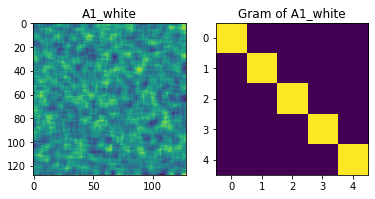

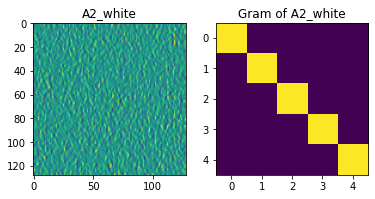

In [46]:
# apply whitening (get relevant SVD vectors)
def whiten(A):
    Avec = A.reshape((channels,hw*hw))
    u,s,vt = np.linalg.svd(Avec,full_matrices=False)
    A_white = (u @ vt).reshape((channels,hw,hw)) # no usage of the singular values here
    return A_white, (u, s, vt), Avec
    
A1_white, A1SVD, A1vec = whiten(A1)
A2_white, A2SVD, A2vec = whiten(A2)

show_gram(A1_white,'A1_white')
show_gram(A2_white,'A2_white')


Now we can transfer the covariances of the activations (i.e., the Grammian) from one matrix to another. This can be achieved in a few ways. The first is given by:

$$ 
\begin{align}
\widehat{A}_{c} =& flatten(A_c) &\widehat{A}_{s} =& flatten(A_s) \\
\widehat{A}_{c} =& U_c\cdot\Sigma_c\cdot V_c^T & \widehat{A}_{s} =& U_s\cdot\Sigma_s\cdot V_s^T \\
\widehat{A}_{s\leftarrow c} =& \underbrace{U_s\cdot\Sigma_s}_{\text{from s}}\underbrace{\cdot V_c^T}_{\text{from c}} &\widehat{A}_{c\leftarrow s} =& \underbrace{U_c\cdot\Sigma_c}_{\text{from c}}\underbrace{\cdot V_s^T}_{\text{from s}} \\
A_{s\leftarrow c} =& reshape(\widehat{A}_{s\leftarrow c}) & A_{c\leftarrow s} =& reshape(\widehat{A}_{c\leftarrow sf}) \\
\end{align}
$$

A1 average content difference: 0.007329761657103312
A2 average content difference: 0.007329761657103315


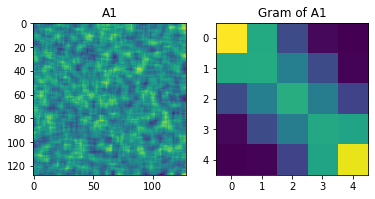

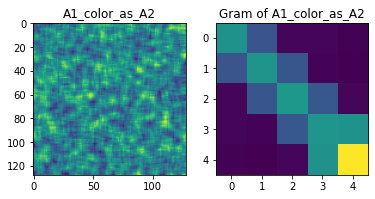

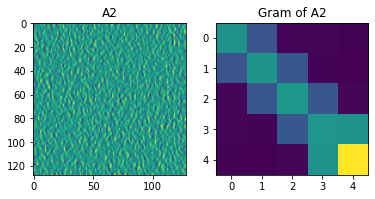

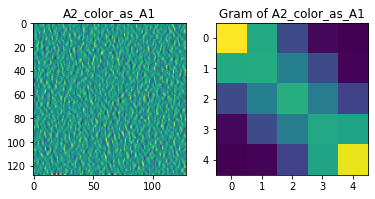

In [47]:
u1, s1, v1 = A1SVD
u2, s2, v2 = A2SVD

# Apply coloring 
A1_color_as_A2 = (u2 @ np.diag(s2) @ v1).reshape((channels,hw,hw))
A2_color_as_A1 = (u1 @ np.diag(s1) @ v2).reshape((channels,hw,hw))

# show originals
# and colored versions
diffA1 = np.mean((A1_color_as_A2-A1)**2)
diffA2 = np.mean((A2_color_as_A1-A2)**2)

print('A1 average content difference:', diffA1)
print('A2 average content difference:', diffA2)

show_gram(A1,'A1')
show_gram(A1_color_as_A2,'A1_color_as_A2')

show_gram(A2,'A2')
show_gram(A2_color_as_A1,'A2_color_as_A1')

____
Now, there is a (potentially) slight problem with the matrices above. The transformations require VERY precise computation for the SVD. And, they require that the A1 and A2 activations are the exact same size. That is really limiting. We can get the same results by first calcualting the SVD of the covariance matrix and applying these to the activations? Yes! We can perform a much simpler SVD in this way.  

Notice also that the activations are much closer in content to one another, but the values from the Grammian are also transferred exactly. See the differences below compared to using the left and right eigenvectors from SVD.

$$ 
\begin{align}
Af_{c} =& flatten(A_c) & Af_{s} =& flatten(A_s) \\
\widehat{Af}_{c} =& U_c\cdot\frac{1}{\sqrt{\Sigma_c}}\cdot U_c^T \cdot Af_{c} &
\widehat{Af}_{s} =& U_s\cdot\frac{1}{\sqrt{\Sigma_s}}\cdot U_s^T \cdot Af_{s} \\
\widehat{A}_{s\leftarrow\approx c} =& U_s\cdot\sqrt{\Sigma_s}\cdot U_s^T \cdot \widehat{Af}_{c}   &
\widehat{A}_{c\leftarrow\approx s} =& U_c\cdot\sqrt{\Sigma_c}\cdot U_c^T \cdot \widehat{Af}_{s}  \\
A_{s\leftarrow\approx c} =& reshape(\widehat{A}_{s\leftarrow\approx c}) & A_{c\leftarrow\approx s} =& reshape(\widehat{A}_{c\leftarrow\approx sf}) \\
\end{align}
$$

A1 average content difference: 0.003038863236308717
A2 average content difference: 0.0030388632363087084


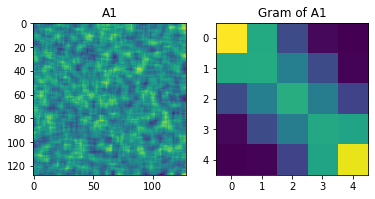

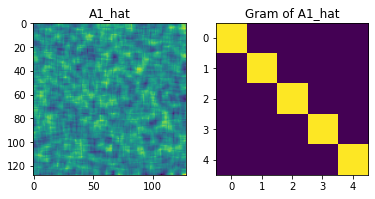

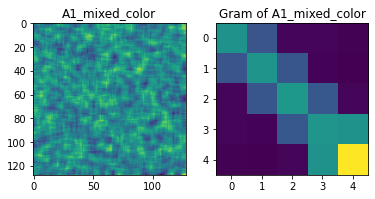

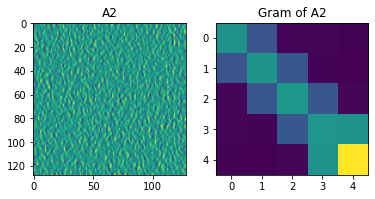

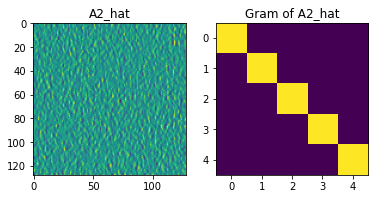

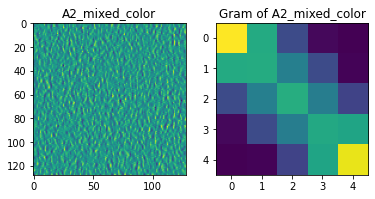

In [51]:
# apply whitening (get relevant SVD vectors)
def whiten_cov(A):
    Avec = A.reshape((channels,hw*hw))
    AA = Avec @ Avec.T
    # notice that the SVD is of the covariance matrix
    u,s,vt = np.linalg.svd(AA,full_matrices=False)
    
    A_white = ((u @ np.diag(s**(-0.5)) @ vt) @ Avec) # no usage of the singular values here
    return A_white, (u, s, vt), Avec
    

A1_white, A1SVDcov, A1vec = whiten_cov(A1)
A2_white, A2SVDcov, A2vec = whiten_cov(A2)
    
u1, s1, _ = A1SVDcov
u2, s2, _ = A2SVDcov

# -------A1-------
# Apply inverse reconstruction to get colored version
A1_mixed_color = u2 @ np.diag(s2**(0.5)) @ u2.T @ A1_white
A1_mixed_color = A1_mixed_color.reshape((channels,hw,hw))

# -------A2-------
# Apply inverse reconstruction to get colored version
A2_mixed_color = u1 @ np.diag(s1**(0.5)) @ u1.T @ A2_white
A2_mixed_color = A2_mixed_color.reshape((channels,hw,hw))

diffA1 = np.mean((A1_mixed_color-A1)**2)
diffA2 = np.mean((A2_mixed_color-A2)**2)

print('A1 average content difference:', diffA1)
print('A2 average content difference:', diffA2)

# show originals
# and colored versions
show_gram(A1,'A1')
show_gram(A1_white.reshape((channels,hw,hw)),'A1_white')
show_gram(A1_mixed_color,'A1_mixed_color')

# show originals
# and colored versions
show_gram(A2,'A2')
show_gram(A2_white.reshape((channels,hw,hw)),'A2_white')
show_gram(A2_mixed_color,'A2_mixed_color')

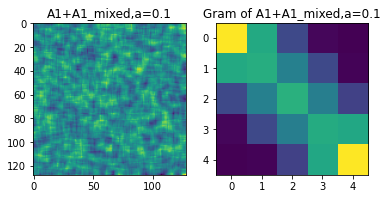

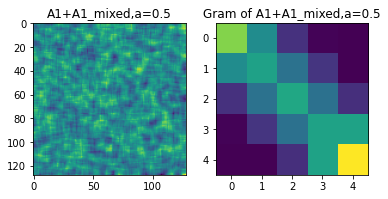

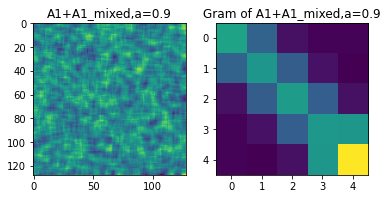

In [52]:
# Another trick we can use to insert more content
# back into the matrix is to take a weighted sum
# of the colored contetn and original content 
for alpha in [0.1, 0.5, 0.9]:
    show_gram(alpha*A1_mixed_color+(1-alpha)*A1,f'A1+A1_mixed,a={alpha}')
